In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output
from src.utils import deflection_biexp_calc, bi_exponential_deflection
from optimize_conditional import create_energy_axis
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.append('.')

# Import your modules
from src.modules_1d import EDMPrecond
from src.diffusion import EdmSampler

# Set up matplotlib
plt.style.use('default')
%matplotlib inline

In [2]:
# Configuration
CONFIG = {
    'run_name': 'edm_1d_spectrum_256pts_instancenorm_fixeddataset_10kEpochs',
    'model_dir': 'models',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'resolution': 256,
    'features': ['E', 'P', 'ms'],
    'settings_dim': 3,
    'num_steps': 30,  # Sampling steps (can be adjusted)
    'cfg_scale': 3.0,  # Classifier-free guidance scale
}

print(f"Using device: {CONFIG['device']}")
print(f"Model configuration: {CONFIG}")

Using device: cuda
Model configuration: {'run_name': 'edm_1d_spectrum_256pts_instancenorm_fixeddataset_10kEpochs', 'model_dir': 'models', 'device': 'cuda', 'resolution': 256, 'features': ['E', 'P', 'ms'], 'settings_dim': 3, 'num_steps': 30, 'cfg_scale': 3.0}


In [3]:
def calculate_weighted_sum(spectrum, energy_values, device='cuda'):
        """
        Calculate the weighted sum of intensities multiplied by MeV values.
        
        Args:
            spectrum (torch.Tensor): The intensity values of the spectrum
            energy_values (torch.Tensor): The corresponding energy values (MeV)
            
        Returns:
            torch.Tensor: Sum of intensities * MeV values
        """
        # Ensure inputs are on the correct device
        # spectrum = spectrum.to(device)
        # energy_values = energy_values.to(device)
        
        # Calculate weighted sum: sum(intensity * MeV)
        print(spectrum.shape, energy_values.shape)
        mean_spectrum = np.mean(spectrum, axis=0)
        weighted_sum = np.sum(mean_spectrum * energy_values)
        return weighted_sum

def load_trained_model(config):
    """Load the trained diffusion model."""
    
    # Initialize model
    model = EDMPrecond(
        resolution=config['resolution'],
        settings_dim=config['settings_dim'],
        sigma_min=0,
        sigma_max=float('inf'),
        sigma_data=0.112,
        model_type='UNet_conditional',
        device=config['device']
    ).to(config['device'])
    
    # Look for checkpoint files
    model_path = os.path.join(config['model_dir'], config['run_name'])
    
    # Try different checkpoint names
    checkpoint_files = [
        'ema_ckpt_final.pt',
        'ema_ckpt.pt',
    ]
    
    # Also look for epoch-specific checkpoints
    if os.path.exists(model_path):
        epoch_files = [f for f in os.listdir(model_path) if f.startswith('ema_ckpt_epoch_') and f.endswith('.pt')]
        if epoch_files:
            # Sort by epoch number and take the latest
            epoch_files.sort(key=lambda x: int(x.split('_')[3].split('.')[0]))
            checkpoint_files.insert(0, epoch_files[-1])  # Add latest epoch to the front
    
    checkpoint_path = None
    for checkpoint_file in checkpoint_files:
        potential_path = os.path.join(model_path, checkpoint_file)
        if os.path.exists(potential_path):
            checkpoint_path = potential_path
            break
    
    if checkpoint_path is None:
        raise FileNotFoundError(f"No checkpoint found in {model_path}. Available files: {os.listdir(model_path) if os.path.exists(model_path) else 'Directory not found'}")
    
    print(f"Loading checkpoint: {checkpoint_path}")
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=config['device'])
    model.load_state_dict(checkpoint)
    model.eval()
    
    print(f"✅ Model loaded successfully from {os.path.basename(checkpoint_path)}")
    return model

# Load the model
try:
    model = load_trained_model(CONFIG)
    sampler = EdmSampler(net=model, num_steps=CONFIG['num_steps'])
    print(f"✅ Sampler initialized with {CONFIG['num_steps']} steps")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please make sure you have trained a model first!")
    model = None
    sampler = None

def sample_spectra(model, sampler, settings, n_samples=1, cfg_scale=3.0, device='cuda'):
    """
    Generate spectra given experimental settings.
    
    Args:
        model: Trained diffusion model
        sampler: EDM sampler
        settings: List or array of experimental parameters [E, P, ms]
        n_samples: Number of spectra to generate
        cfg_scale: Classifier-free guidance scale
        device: Device to use for computation
    
    Returns:
        Generated spectra as numpy array
    """
    if model is None or sampler is None:
        print("❌ Model not loaded. Please run the model loading cell first.")
        return None
    
    model.eval()
    
    with torch.no_grad():
        # Convert settings to tensor
        if isinstance(settings, (list, tuple)):
            settings = np.array(settings)
        
        settings_tensor = torch.tensor(settings, dtype=torch.float32).reshape(1, -1).to(device)
        
        # Generate samples
        samples = sampler.sample(
            resolution=CONFIG['resolution'],
            device=device,
            settings=settings_tensor,
            n_samples=n_samples,
            cfg_scale=cfg_scale,
            settings_dim=CONFIG['settings_dim'],
            smooth_output=True,
            smooth_kernel_size=9,
            smooth_sigma=2.0
        )
        
        # Convert to numpy
        samples_np = samples.cpu().numpy()
        
        return samples_np

def plot_generated_spectra(spectra, settings, energy_axis=None, title=None):
    """Plot generated spectra."""
    if energy_axis is None:
        energy_axis = create_energy_axis(spectra.shape[-1])
    # print(energy_axis)
    
    plt.figure(figsize=(12, 6))
    
    # Handle different input shapes
    if spectra.ndim == 3:  # (n_samples, channels, length)
        spectra_2d = spectra[:, 0, :]  # Take first channel
    elif spectra.ndim == 2:  # (n_samples, length)
        spectra_2d = spectra
    else:  # 1D
        spectra_2d = spectra.reshape(1, -1)
    
    # Plot each spectrum
    for i, spectrum in enumerate(spectra_2d):
        label = f'Sample {i+1}' if len(spectra_2d) > 1 else 'Generated Spectrum'
        plt.plot(energy_axis, spectrum, linewidth=1.5, label=label, alpha=0.8)
    
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Intensity')
    
    if title is None:
        title = f'Generated Spectrum (E={settings[0]:.1f}, P={settings[1]:.1f}, ms={settings[2]:.1f})'
    plt.title(title)
    
    if len(spectra_2d) > 1:
        plt.legend()
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    # print(energy_axis[::-1])
    print("Average weighted sum: ", calculate_weighted_sum(spectra, energy_axis[::-1]))
    
    return plt.gcf()

Loading checkpoint: models/edm_1d_spectrum_256pts_instancenorm_fixeddataset_10kEpochs/ema_ckpt_epoch_10000.pt
✅ Model loaded successfully from ema_ckpt_epoch_10000.pt
✅ Sampler initialized with 30 steps


Generating 4 spectra with settings: E=10, P=50, ms=20
Using CFG scale: 3.0
✅ Generated spectra shape: (4, 1, 256)


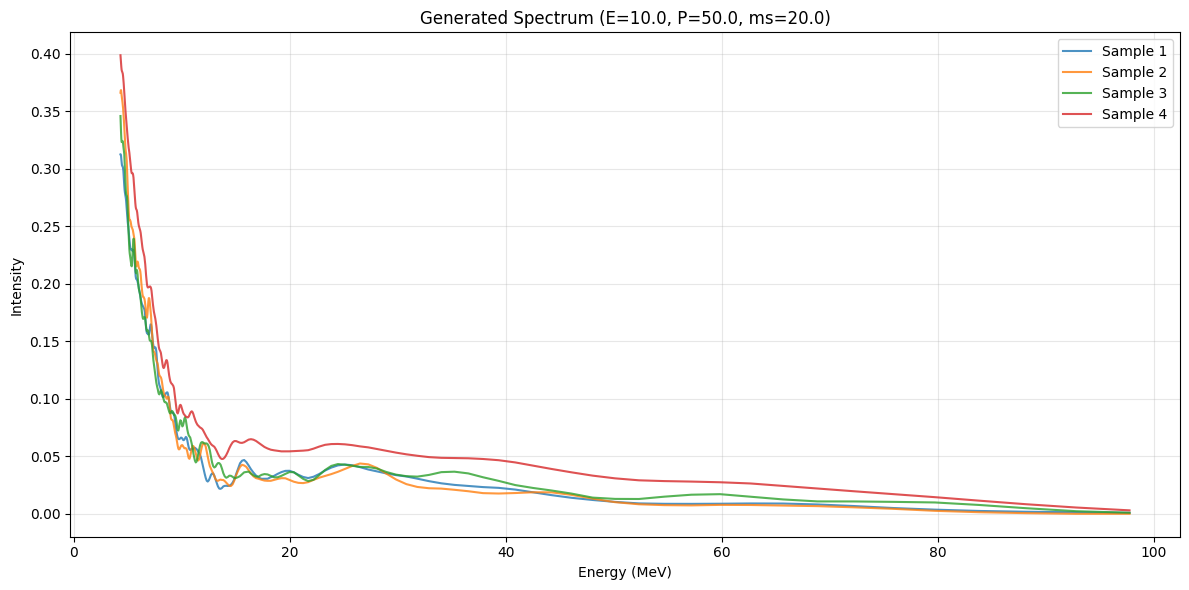

(4, 1, 256) (256,)
Average weighted sum:  833.2019

Spectrum Statistics:
  Intensity range: [0.0000, 0.3985]
  Mean intensity: 0.1248
  Std intensity: 0.0996


<Figure size 640x480 with 0 Axes>

In [9]:
# Example: Generate spectrum with specific parameters
example_settings = [10, 50, 20]  # [E, P, ms]
n_samples = 4  # Generate 3 samples
cfg_scale = 3.0  # Classifier-free guidance scale

print(f"Generating {n_samples} spectra with settings: E={example_settings[0]}, P={example_settings[1]}, ms={example_settings[2]}")
print(f"Using CFG scale: {cfg_scale}")

# Generate spectra
generated_spectra = sample_spectra(
    model, sampler, 
    settings=example_settings, 
    n_samples=n_samples, 
    cfg_scale=cfg_scale, 
    device=CONFIG['device']
)

if generated_spectra is not None:
    print(f"✅ Generated spectra shape: {generated_spectra.shape}")
    
    # Plot the results
    energy_axis = create_energy_axis(CONFIG['resolution'])
    plot_generated_spectra(generated_spectra, example_settings, energy_axis)
    
    # Print statistics
    print(f"\nSpectrum Statistics:")
    print(f"  Intensity range: [{generated_spectra.min():.4f}, {generated_spectra.max():.4f}]")
    print(f"  Mean intensity: {generated_spectra.mean():.4f}")
    print(f"  Std intensity: {generated_spectra.std():.4f}")